# An analysis of the OLM Common Crawl datasets

The OLM datasets are snapshots of the internet from Common Crawl (https://commoncrawl.org/) which are cleaned, deduplicated, and filtered for English. We plan to release a new OLM dataset with each new Common Crawl snapshot, roughly every month. We will continuously train always-up-to-date language models with this growing collection of datasets. The repo for this project is here: https://github.com/huggingface/olm-datasets

How frequently is the website text in our datasets updated? What is the domain distribution within an OLM dataset and how does it compare to OLM datasets for other Common Crawl snapshots? In this notebook, you'll see answers to these questions!

This notebook has a simplified version of the analysis that you can do here: https://github.com/huggingface/olm-datasets/tree/main/analysis_scripts. This notebook doesn't have enough CPUs to run the analysis on the full Common Crawl OLM datasets in a reasonable amount of time. So, our notebook uses samples from the datasets. The notebook includes results for cases where sampling is okay to do (e.g. getting a sense of the domain distributions and timestamp distributions) and leaves out results where it is important to use the whole dataset (e.g. knowing the percent of duplicate URLs).

Let's start by installing our dependencies!

In [ ]:
!pip install datasets

# How up-to-date are our datasets?

In this section, we will investigate how up-to-date the Common Crawl OLM datasets are. We will check out the Last-Modified headers returned by webpages for each text example where it is available, and compare that with the timestamp that the webpages were crawled by Common Crawl. Finally, we will look at the relative frequencies of date mentions in URLs for each example.



## Last-modified timestamp versus crawl timestamp

Run the following code to plot the last-modified header distribution. Change `timestamp_column` to be `"crawl_timestamp"` and run it again. What do we find? The mean `last_modified_timestamp` only lags a few days behind the mean `crawl_timestamp` for each of our datasets. So, we have evidence that the text in our datasets is very up-to-date!

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

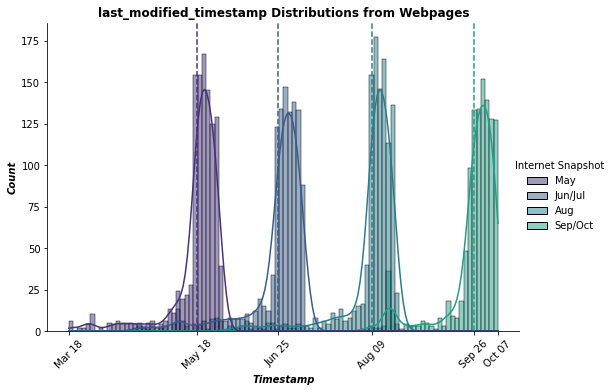

In [ ]:
from datasets import load_dataset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

timestamp_column = "last_modified_timestamp"  # TODO: change me to "crawl_timestamp" for another analysis!
samples = 10000
input_dataset_names = [
    "olm/olm-CC-MAIN-2022-21-sampling-ratio-0.14775510204",
    "olm/olm-CC-MAIN-2022-27-sampling-ratio-0.16142697881",
    "olm/olm-CC-MAIN-2022-33-sampling-ratio-0.20",
    "olm/olm-CC-MAIN-2022-40-sampling-ratio-0.15894621295"

]
input_dataset_pretty_names = [
    "May",
    "Jun/Jul",
    "Aug",
    "Sep/Oct"
]
plot_title = f"{timestamp_column} Distributions from Webpages"
legend_title = "Internet Snapshot"
bins = 100

# Remove timestamp outliers more than 10 median deviations away from the median.
# This is important if the timestamp is the Last-Modified timestamp, which can sometimes be wrong
# because websites can report whatever they want. We don't want one website that says it was created
# a billion years ago to seriously affect the distribution.
def reject_outliers(data, m = 10.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

# Get the timestamps.
data_list = []
shortest_len = None
for input_dataset_name in input_dataset_names:
    ds = load_dataset(input_dataset_name, split="train", streaming=True)

    # The ds is already shuffled so we can select the first elements from the
    # dataset and get a random sample
    ds_sample = {timestamp_column: []}
    index = 0
    for obj in ds:
      ds_sample[timestamp_column].append(obj[timestamp_column])
      index += 1
      if index >= samples:
        break
    ds_sample = Dataset.from_dict(ds_sample)

    ds_sample = ds_sample.filter(lambda example: example[timestamp_column] is not None)

    data = np.array(ds_sample[timestamp_column])
    data_no_outliers = reject_outliers(data)
    data_list.append(data_no_outliers)
    if shortest_len is None:
        shortest_len = len(data_no_outliers)
    else:
        shortest_len = min(shortest_len, len(data_no_outliers))

# Make the plot.
truncated_data_list = []
for data in data_list:
  truncated_data_list.append(data[:shortest_len])
data_array = np.array(truncated_data_list).transpose()
df = pd.DataFrame(data=data_array, columns=input_dataset_pretty_names)
color_palette = sns.color_palette("viridis")
colors = color_palette[:len(input_dataset_names)]
plot = sns.displot(data=df, kde=True, palette=colors, bins=bins, height=5, aspect=1.5)
means = np.mean(data_array, axis=0)
xticks = np.concatenate((np.array([np.min(data_array)]), means, np.array([np.max(data_array)])))
for mean, color in zip(means, colors):
    plt.axvline(x=mean, linestyle="--", color=color)
plot.set(xticks=xticks)
plot.axes[0,0].set_title(plot_title, fontweight="bold")
plot.axes[0,0].set_xlabel("Timestamp", style="italic", fontweight="bold")
plot.axes[0,0].set_ylabel("Count", style="italic", fontweight="bold")
plot.set_xticklabels([datetime.fromtimestamp(timestamp).strftime('%b %d') for timestamp in xticks], rotation=45)
plot._legend.set_title(legend_title)
plot.figure.show()

## Date Mentions in URLs

Run the following code. It counts the date mentions (in YYYY/MM format) in the URLs of all of the datasets. It then plots a figure which represents the ratio of the date mentions for each dataset. We find that there is about a month of lag, but the dates in the URLs are updated reasonably frequently. You could do the same analysis with `analysis_column="text"` instead of the `"url"` in the code below. But you'll need many more samples to see the same pattern emerge (it does emerge though!).

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

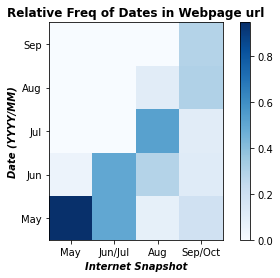

In [ ]:
from datasets import load_dataset, Dataset
import numpy as np
import matplotlib.pyplot as plt

analysis_column = "url"
samples = 10000
input_dataset_names = [
    "Tristan/olm-CC-MAIN-2022-21-sampling-ratio-0.14775510204",
    "Tristan/olm-CC-MAIN-2022-27-sampling-ratio-0.16142697881",
    "Tristan/olm-CC-MAIN-2022-33-sampling-ratio-0.20",
    "Tristan/olm-CC-MAIN-2022-40-sampling-ratio-0.15894621295"

]
input_dataset_pretty_names = [
    "May",
    "Jun/Jul",
    "Aug",
    "Sep/Oct"
]
terms = [
    "2022/05",
    "2022/06",
    "2022/07",
    "2022/08",
    "2022/09"
]
term_pretty_names = [
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep"
]
xlabel = "Internet Snapshot"
ylabel = "Date (YYYY/MM)"
plot_title = f"Relative Freq of Dates in Webpage {analysis_column}"

# Compute the counts.
term_y_coords = {term: [] for term in terms}
for input_dataset_name in input_dataset_names:

    ds = load_dataset(input_dataset_name, split="train", streaming=True)

    # The ds is already shuffled so we can select the first elements from the
    # dataset and get a random sample.
    ds_sample = {analysis_column: []}
    index = 0
    for obj in ds:
      ds_sample[analysis_column].append(obj[analysis_column])
      index += 1
      if index >= samples:
        break
    ds_sample = Dataset.from_dict(ds_sample)

    def term_counts(text):
      return {term + "_count": text.lower().count(term.lower()) for term in terms}

    ds_sample = ds_sample.map(lambda example: term_counts(example[analysis_column]))

    for term in terms:
        term_y_coords[term].append(sum(ds_sample[term + "_count"]))


# Plot the counts as a heatmap.
plt.xticks(range(len(input_dataset_pretty_names)), input_dataset_pretty_names)
matrix = []
for term in terms:
    matrix.append(term_y_coords[term])
matrix = np.array(matrix)
column_sums = matrix.sum(axis=0)
normalized_matrix = matrix / column_sums
plt.imshow(np.flipud(normalized_matrix), plt.cm.Blues)
plt.yticks(range(len(terms)), reversed(terms if term_pretty_names is None else term_pretty_names))
cbar = plt.colorbar()
plt.ylabel(ylabel, style='italic', fontweight="bold")
plt.xlabel(xlabel, style='italic', fontweight="bold")
plt.title(plot_title, fontweight="bold")
plt.show()

# What is the URL domain distribution for one of our datasets? How do the URL domain distributions for each of our datasets compare?

Run the following code to generate the correlation matrix for the histogram of URL domains between each dataset. The code also prints out the histogram itself for the May dataset. The correlations are only weak because of the small number of samples that we use. The correlations would mostly be around 0.7 or 0.8 if we used the whole datasets. Nevertheless, you can see the general pattern that datasets that are temporally closer have a stronger URL domain correlation than ones that are several months apart.

  0%|          | 0/100 [00:00<?, ?ba/s]

100%|██████████| 99/99 [00:00<00:00, 242.11it/s]


  0%|          | 0/100 [00:00<?, ?ba/s]

100%|██████████| 99/99 [00:00<00:00, 221.84it/s]


  0%|          | 0/100 [00:00<?, ?ba/s]

100%|██████████| 99/99 [00:00<00:00, 193.26it/s]


  0%|          | 0/100 [00:00<?, ?ba/s]

100%|██████████| 306279/306279 [00:01<00:00, 304669.97it/s]


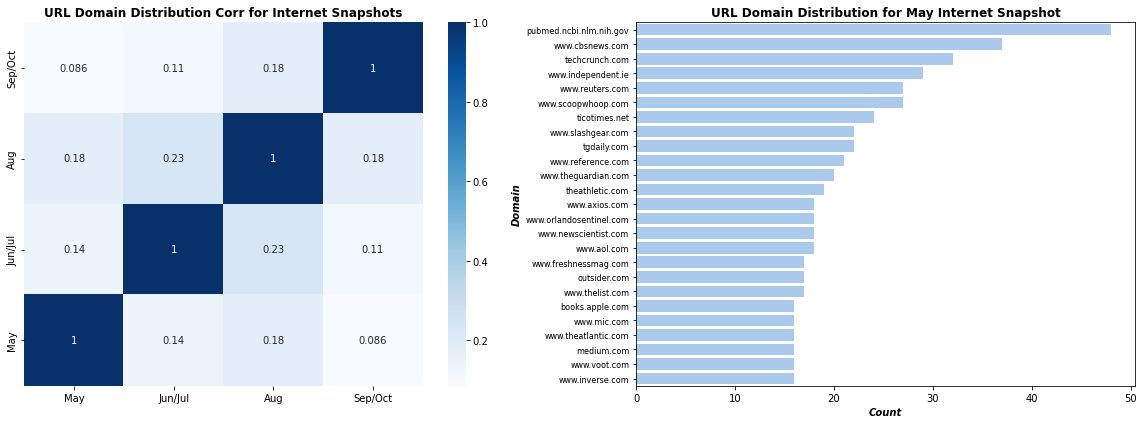

In [ ]:
from datasets import load_dataset, load_from_disk
import argparse
from tqdm import tqdm
from collections import Counter
from urllib.parse import urlparse
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

url_column = "url"
samples = 100000
input_dataset_names = [
    "olm/olm-CC-MAIN-2022-21-sampling-ratio-0.14775510204",
    "olm/olm-CC-MAIN-2022-27-sampling-ratio-0.16142697881",
    "olm/olm-CC-MAIN-2022-33-sampling-ratio-0.20",
    "olm/olm-CC-MAIN-2022-40-sampling-ratio-0.15894621295"

]
input_dataset_pretty_names = [
    "May",
    "Jun/Jul",
    "Aug",
    "Sep/Oct"
]

# Get the domain counts.
count_dicts = []
for input_dataset_name in input_dataset_names:

    ds = load_dataset(input_dataset_name, split="train", streaming=True)

    # The ds is already shuffled so we can select the first elements from the
    # dataset and get a random sample
    ds_sample = {url_column: []}
    index = 0
    for obj in ds:
      ds_sample[url_column].append(obj[url_column])
      index += 1
      if index >= samples:
        break
    ds_sample = Dataset.from_dict(ds_sample)

    shared_list = []
    def build_count_dict(examples):
        counts = None
        for url in examples[url_column]:
            domain = urlparse(url).netloc
            if counts is None:
                counts = Counter([domain])
            else:
                counts += Counter([domain])
        shared_list.append(counts)

    ds_sample.map(build_count_dict, batched=True)

    count_dict = shared_list[0]
    for counts in tqdm(shared_list[1:]):
        count_dict += counts

    count_dicts.append(count_dict)

union_count_set = set(count_dicts[0].keys())
for count_dict in tqdm(count_dicts[1:]):
    union_count_set = union_count_set.union(set(count_dict.keys()))

dataframe_dict = {dataset_name: [] for dataset_name in input_dataset_pretty_names}
dataframe_dict["domain_name"] = []
for domain in tqdm(union_count_set):
    for index in range(len(input_dataset_pretty_names)):
        count_dict = count_dicts[index]
        dataset_name = input_dataset_pretty_names[index]
        dataframe_dict[dataset_name].append(count_dict.get(domain, 0))
    dataframe_dict["domain_name"].append(domain)
df = pd.DataFrame(dataframe_dict)

fig, axs = plt.subplots(ncols=2, figsize=(16,6))

# Plot the correlation between the domain distributions for each snapshot sample.
corr_plot_title = "URL Domain Distribution Corr for Internet Snapshots"
plot = sns.heatmap(df.corr().iloc[::-1], cmap="Blues", annot=True, ax=axs[0])
plot.set_title(corr_plot_title, fontweight="bold")

# Plot the domain distribution for the May OLM dataset sample.
hist_bins = 25
hist_plot_title = "URL Domain Distribution for May Internet Snapshot"
hist_bin_fontsize = 8
df = df.sort_values(by=input_dataset_pretty_names, ascending=False)
dataframe_dict = {"samples": [], "dataset": [], "domain": []}
index = 0
for _, datum in df.iterrows():
    if index >= hist_bins:
        break
    dataframe_dict["samples"] += [datum[name] for name in input_dataset_pretty_names]
    dataframe_dict["dataset"] += input_dataset_pretty_names
    dataframe_dict["domain"] += [datum["domain_name"]]*len(input_dataset_pretty_names)
    index += 1
df = pd.DataFrame(dataframe_dict)
df = df[df["dataset"] == "May"]
color_palette = sns.color_palette("pastel")
colors = color_palette[:1]
plot = sns.barplot(data=df, palette=colors, hue="dataset", y="domain", x="samples", ax=axs[1])
plot.legend().set_title("")
plot.legend().remove()
for item in plot.get_yticklabels():
    item.set_fontsize(hist_bin_fontsize)
plot.set_title(hist_plot_title, fontweight="bold")
plot.set_xlabel("Count", style="italic", fontweight="bold")
plot.set_ylabel("Domain", style="italic", fontweight="bold")

plt.tight_layout()
plt.show()